## Historical Price Data EDA

In [1]:
import os
os.chdir(os.environ['PWD'])

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from conf import settings as sts
from conf import utils as uts
from unidecode import unidecode
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felipegonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Import Historical Data

In [18]:
dataset = pd.read_csv(sts.LOCAL_DATA_PATH+"final_prices_dataset_clean.csv")

In [25]:
dataset['date'] = pd.to_datetime(dataset['date'])

## Time Series Forecasting

In [31]:
dataset_pivot = dataset.pivot(index='date', columns = ['group', 'product', 'market'], values = 'mean_price')

In [32]:
dataset_pivot = dataset_pivot.reindex(date_range)

In [33]:
price_series = dataset_pivot.loc[:, [('frutas','manzana roja importada','medellin central mayorista de antioquia')]].squeeze()

In [34]:
y = price_series.copy()

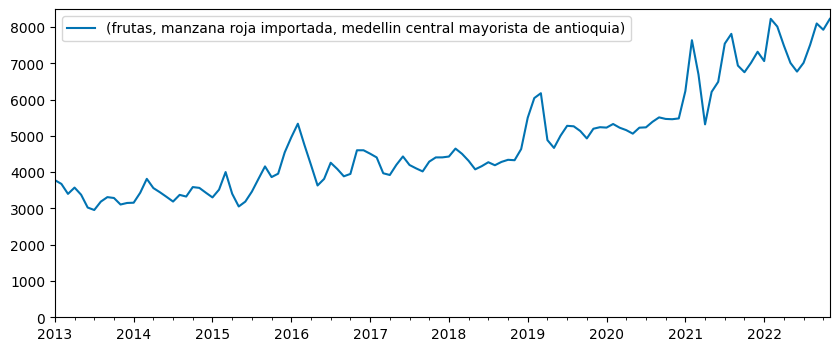

In [35]:
plt.figure(figsize=(10,4))
y.plot()
plt.ylim(bottom=0)
plt.legend()
plt.show()

#### Time Series Decomposition w/ LOESS

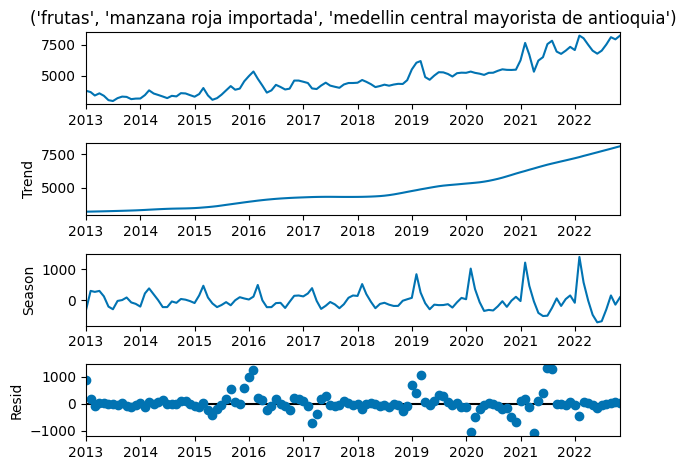

In [36]:
stl = STL(y, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

In [37]:
f_t = max(0, 1 - res_robust.resid.var()/(res_robust.trend + res_robust.resid).var())
print("f_t", f_t)

f_t 0.9362974774599554


In [38]:
f_s = max(0, 1 - res_robust.resid.var()/(res_robust.seasonal + res_robust.resid).var())
print("f_s", f_s)

f_s 0.3159119988186687


### Input Features

#### Trend and Seasonality

In [39]:
dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order = (2 if f_t > 0.5 else 0),
    drop = True,
    seasonal = (True if f_s > 0.5 else False)
)

In [40]:
X_1 = dp.in_sample()

In [41]:
model_1 = LinearRegression().fit(X_1, y)

y_fitted = pd.Series(model_1.predict(X_1), index=X_1.index)
ax = y.plot()
ax = y_fitted.plot()
ax.legend()
plt.ylim(bottom=0)
plt.show()

NameError: name 'LinearRegression' is not defined

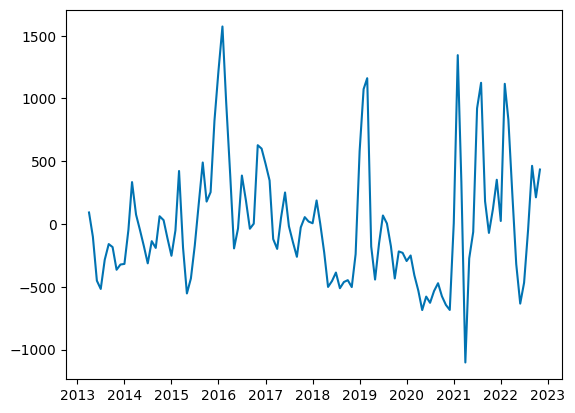

In [173]:
residuals = y - y_pred
plt.plot(residuals)
plt.show()

In [174]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [175]:
X_2 = make_lags(residuals, 3)

In [176]:
X_2

,y_lag_1,y_lag_2,y_lag_3
2013-01-01,NaN,NaN,NaN
2013-02-01,NaN,NaN,NaN
2013-03-01,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN
2013-05-01,91.696940,NaN,NaN
...,...,...,...
2022-07-01,-634.076902,-319.026920,233.300506
2022-08-01,-467.849441,-634.076902,-319.026920
2022-09-01,-47.344536,-467.849441,-634.076902
2022-10-01,463.437813,-47.344536,-467.849441


In [ ]:
X_2 = make_lags(residuals, 3).dropna()
y_2 = make_multistep_target(residuals, 3).dropna()

In [162]:
y_2, X_2 = y_2.align(X_2, join='inner', axis=0)

In [163]:
y_2

,y_step_1,y_step_2,y_step_3
2013-04-01,91.696940,-101.594420,-451.608337
2013-05-01,-101.594420,-451.608337,-517.344809
2013-06-01,-451.608337,-517.344809,-284.803838
2013-07-01,-517.344809,-284.803838,-159.985423
2013-08-01,-284.803838,-159.985423,-183.889564
...,...,...,...
2022-05-01,-319.026920,-634.076902,-467.849441
2022-06-01,-634.076902,-467.849441,-47.344536
2022-07-01,-467.849441,-47.344536,463.437813
2022-08-01,-47.344536,463.437813,212.497606


In [164]:
X_2

,y_lag_1,y_lag_2,y_lag_3
2013-04-01,-86.734256,183.111991,282.235683
2013-05-01,91.696940,-86.734256,183.111991
2013-06-01,-101.594420,91.696940,-86.734256
2013-07-01,-451.608337,-101.594420,91.696940
2013-08-01,-517.344809,-451.608337,-101.594420
...,...,...,...
2022-05-01,233.300506,830.905376,1116.787690
2022-06-01,-319.026920,233.300506,830.905376
2022-07-01,-634.076902,-319.026920,233.300506
2022-08-01,-467.849441,-634.076902,-319.026920


In [165]:
from xgboost import XGBRegressor

In [1]:
xgb = XGBRegressor()

NameError: name 'XGBRegressor' is not defined